# Import libraries

In [1]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, InputLayer, Activation, Dropout, Dense, Input, BatchNormalization, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
from keras_self_attention import SeqSelfAttention
from matplotlib import pyplot as plt

# Data Preprocessing

#### Import Datasets

In [2]:
train = pd.read_csv('sentiment/train.csv').set_axis(['headlines', 'sentiment'], axis=1, inplace=False)
test = pd.read_csv('sentiment/test.csv').set_axis(['headlines', 'sentiment'], axis=1, inplace=False)
validation = pd.read_csv('sentiment/validation.csv').set_axis(['headlines', 'sentiment'], axis=1, inplace=False)

#### Convert to lowercase

In [3]:
train['headlines'] = train['headlines'].str.lower()
test['headlines'] = test['headlines'].str.lower()
validation['headlines'] = validation['headlines'].str.lower()

#### Stop words removal

In [4]:
stopwords = set(stopwords.words('english'))

train['headlines'] = train['headlines'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
test['headlines'] = test['headlines'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
validation['headlines'] = validation['headlines'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))

#### Tags removal

In [5]:
def remove_tags(data):
    result = re.sub(r'[^\w\s]','',data)
    return result

train['headlines']= train['headlines'].apply(lambda cw : remove_tags(cw))
train['headlines'] = train['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

test['headlines']= test['headlines'].apply(lambda cw : remove_tags(cw))
test['headlines'] = test['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

validation['headlines']= validation['headlines'].apply(lambda cw : remove_tags(cw))
validation['headlines'] = validation['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')

<ipython-input-5-37be2ef99ef5>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train['headlines'] = train['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-5-37be2ef99ef5>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  test['headlines'] = test['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-5-37be2ef99ef5>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  validation['headlines'] = validation['headlines'].str.replace('[{}]'.format(string.punctuation), ' ')


#### Transform Target Variables

In [6]:
def transform(data):
    for i in data.index:
        
        if data['sentiment'][i] == 1:
            data['sentiment'][i] = 2
        
        elif data['sentiment'][i] == 0:
            data['sentiment'][i] = 1
        
        else:
            data['sentiment'][i] = 0
    
    return data

In [7]:
train = transform(train)
validation = transform(validation)
test = transform(test)

<ipython-input-6-c53188f55335>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][i] = 2
<ipython-input-6-c53188f55335>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][i] = 1
<ipython-input-6-c53188f55335>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][i] = 0


#### Data Preparation

In [8]:
X_train = []
X_validation = []
X_test = []

for i in range(len(train['headlines'])):
    X_train.append(train['headlines'][i])
    
for i in range(len(validation['headlines'])):
    X_validation.append(validation['headlines'][i])
    
for i in range(len(test['headlines'])):
    X_test.append(test['headlines'][i])

In [9]:
Y_train = np.array(list(train['sentiment']))
Y_validation = np.array(list(validation['sentiment']))
Y_test = np.array(list(test['sentiment']))


Y_train = to_categorical(Y_train)
Y_validation = to_categorical(Y_validation)
Y_test = to_categorical(Y_test)

In [10]:
X_train

['mmags jets targets annual cargo volume grow 142 five years',
 'civil servants continue provide quality effective service says cuepacs',
 'klci falls 076 tracks regional decline',
 'anzo showing signs developing rebound rhb retail research says',
 'fgv mmc corp guocoland kab london biscuits tadmax yli',
 'valiram announces new additions senior leadership malaysia thailand indonesia',
 'dialog raises stake bayan field independent technical service contractor us822 million',
 'prasarana shifts profitable year target 2021 amid covid19 pandemic',
 'serba dinamik sunway seni jaya airasia group kawan food yong tai',
 'uem sunrise 2q loss narrows amid improved sales higher construction progress',
 'pharmaniaga 2q net profit leaps 72 declares 25 sen interim dividend',
 'klci advances top glove  hartalega lift regional markets mixed simmering chinaus tensions',
 'court grants order freeze rm169m ricky wongs assets alleged fraud involving bright packaging shares',
 'magnum 4d selling advance dr

In [11]:
Y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

#### Tokenize Dataset

In [12]:
X_train_tokens = []
X_test_tokens = []
X_validation_tokens = []

for i in range(len(X_train)):
    tokens = nltk.word_tokenize(X_train[i])
    X_train_tokens.append(tokens)
    
for i in range(len(X_test)):
    tokens = nltk.word_tokenize(X_test[i])
    X_test_tokens.append(tokens)
    
for i in range(len(X_validation)):
    tokens = nltk.word_tokenize(X_validation[i])
    X_validation_tokens.append(tokens)

In [13]:
X_train_tokens

[['mmags',
  'jets',
  'targets',
  'annual',
  'cargo',
  'volume',
  'grow',
  '142',
  'five',
  'years'],
 ['civil',
  'servants',
  'continue',
  'provide',
  'quality',
  'effective',
  'service',
  'says',
  'cuepacs'],
 ['klci', 'falls', '076', 'tracks', 'regional', 'decline'],
 ['anzo',
  'showing',
  'signs',
  'developing',
  'rebound',
  'rhb',
  'retail',
  'research',
  'says'],
 ['fgv',
  'mmc',
  'corp',
  'guocoland',
  'kab',
  'london',
  'biscuits',
  'tadmax',
  'yli'],
 ['valiram',
  'announces',
  'new',
  'additions',
  'senior',
  'leadership',
  'malaysia',
  'thailand',
  'indonesia'],
 ['dialog',
  'raises',
  'stake',
  'bayan',
  'field',
  'independent',
  'technical',
  'service',
  'contractor',
  'us822',
  'million'],
 ['prasarana',
  'shifts',
  'profitable',
  'year',
  'target',
  '2021',
  'amid',
  'covid19',
  'pandemic'],
 ['serba',
  'dinamik',
  'sunway',
  'seni',
  'jaya',
  'airasia',
  'group',
  'kawan',
  'food',
  'yong',
  'tai'],
 ['

# Word Embedding using GloVe 

#### Load Pre-trained Word Vectors

In [14]:
glove_vectors = dict()

file = open('glove.6B.100d.txt',  encoding='UTF-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], dtype='float32')
    glove_vectors[word] = vectors
    
file.close()

dim = glove_vectors["random"].shape[0]

#### Determine Maximum Length of Words in Datasets

In [15]:
max_length = 0

for i in range(len(X_train_tokens)):
    if len(X_train_tokens[i]) > max_length:
        max_length = len(X_train_tokens[i])

for i in range(len(X_test_tokens)):
    if len(X_test_tokens[i]) > max_length:
        max_length = len(X_test_tokens[i])

for i in range(len(X_validation_tokens)):
    if len(X_validation_tokens[i]) > max_length:
        max_length = len(X_validation_tokens[i])

In [16]:
max_length

64

#### Convert data into word vectors

In [17]:
def embed(data):
    
    X = np.zeros((len(data), max_length, dim))
    
    for i in range(len(data)):
        for j in range (len(data[i])):
            try:
                vector = glove_vectors.get(data[i][j])
            except KeyError:
                vector = glove_vectors.get("<unk>")
                X[i][j] = np.array(vector)
            
            if vector is not None:
                X[i][j] = np.array(vector)
                
    return X

In [18]:
X_train_vector = embed(X_train_tokens)
X_test_vector = embed(X_test_tokens)
X_validation_vector = embed(X_validation_tokens)

In [19]:
X_train_vector

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.19419   ,  0.19271   ,  0.81928003, ...,  1.20150006,
          0.56036001, -0.21788999],
        [-0.64783001, -0.25431001, -0.013584  , ...,  0.62453002,
          0.53548998,  0.59232998],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.13209   ,  0.35960001, -0.88736999, ...,  0.16247   ,
          0.020598  , -0.76899999],
        [ 0.27700999, -0.054611  , -0.22119001, ..., -0.29266   ,
          0.35932001, -0.81923997],
        [-0.32731   ,  0.033896  , -0.67982   , ..., -0.40222999,
          0.65513003,  0.65350002],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

## Model Building

In [20]:
tf.keras.regularizers.L2(l2=0.02)

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=(max_length, dim)))
model.add(Bidirectional(LSTM(64, kernel_regularizer='l2')))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 101,379
Trainable params: 101,379
Non-trainable params: 0
__________________________________________________

In [21]:
training = model.fit(X_train_vector, Y_train, batch_size=32, epochs=50, validation_data=(X_validation_vector, Y_validation))

Epoch 1/50
1928/1928 [==============================] - 63s 31ms/step - loss: 1.6452 - accuracy: 0.5318 - val_loss: 1.0041 - val_accuracy: 0.5816
Epoch 2/50
1928/1928 [==============================] - 57s 30ms/step - loss: 0.9726 - accuracy: 0.5840 - val_loss: 0.9671 - val_accuracy: 0.5646
Epoch 3/50
1928/1928 [==============================] - 62s 32ms/step - loss: 0.9321 - accuracy: 0.5914 - val_loss: 0.9306 - val_accuracy: 0.5736
Epoch 4/50
1928/1928 [==============================] - 58s 30ms/step - loss: 0.9116 - accuracy: 0.5929 - val_loss: 0.9648 - val_accuracy: 0.5175
Epoch 5/50
1928/1928 [==============================] - 60s 31ms/step - loss: 0.8998 - accuracy: 0.5933 - val_loss: 0.9475 - val_accuracy: 0.5255
Epoch 6/50
1928/1928 [==============================] - 57s 30ms/step - loss: 0.8915 - accuracy: 0.5985 - val_loss: 0.9510 - val_accuracy: 0.5225
Epoch 7/50
1928/1928 [==============================] - 56s 29ms/step - loss: 0.8855 - accuracy: 0.5971 - val_loss: 0.9506 -

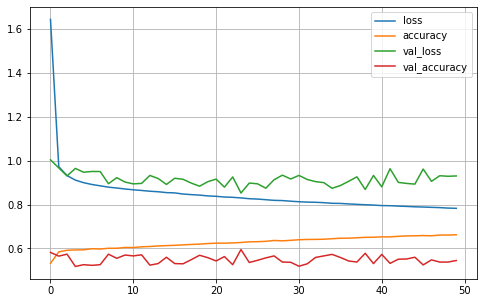

In [22]:
pd.DataFrame(training.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

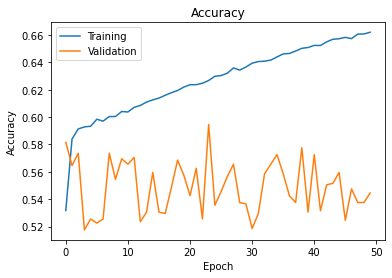

In [23]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

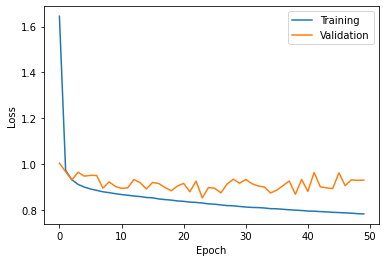

In [24]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

In [25]:
model.evaluate(X_test_vector, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.8319 - accuracy: 0.6296


[0.8319093585014343, 0.6296296119689941]

In [26]:
model.save('BiLSTM')

INFO:tensorflow:Assets written to: BiLSTM\assets


INFO:tensorflow:Assets written to: BiLSTM\assets
